In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
cd ../smore

/home/remedios/smore/smore


In [6]:
from skimage.metrics import peak_signal_noise_ratio
import numpy as np
import nibabel as nib
from pathlib import Path
import matplotlib.pyplot as plt
from utils.plot import *
import pandas as pd
import seaborn as sns

In [7]:
plt.rcParams['figure.figsize'] = (32, 18)
plt.rcParams['figure.facecolor'] = 'black'
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['font.size'] = 18
plt.rcParams['image.cmap'] = 'Greys_r'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['image.interpolation'] = 'nearest'

In [8]:
def multiplot_rows(imgs, titles, nrows, ncols, vmins=None, vmaxs=None):
    fig, axs = plt.subplots(
        nrows=nrows,
        ncols=ncols,
#         figsize=((ncols * plt.rcParams['figure.figsize'][0],
#                   nrows * plt.rcParams['figure.figsize'][1]))
    )
    
    if vmins is None:
        vmins = [img.min() for img in imgs]
    if vmaxs is None:
        vmaxs = [img.max() for img in imgs]

    for ax, img, title, vmin, vmax in zip(axs.reshape(-1), imgs, titles, vmins, vmaxs):
        if vmin is None:
            vmin = img.min()
        if vmax is None:
            vmax = img.max()
        ax.imshow(np.rot90(img), vmin=vmin, vmax=vmax)
        ax.set_title(title)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        ax.spines.left.set_visible(False)
        ax.spines.bottom.set_visible(False)

    plt.show()

In [9]:
gt_fpath = Path("/home/remedios/data/ADNI/ADNI_phantom_1mm_inplane_header_corrected/SUPERRES-ADNIPHANTOM_20200711_PHANTOM-T2-TSE-2D-CORONAL-PRE-ACQ1-01mm_resampled.nii")
gt = nib.load(gt_fpath).get_fdata(dtype=np.float32)

In [10]:
data_range = gt.max() - gt.min()

In [11]:
vmin = gt.min() * 0.1
vmax = gt.max() * 0.9

In [12]:
sr_dir = Path("/home/remedios/data/results/smoreCE/SUPERRES-ADNIPHANTOM_20200711_PHANTOM-T2-TSE-2D-CORONAL-PRE-ACQ1-04mm_resampled/")
sr_files = sorted(sr_dir.iterdir())

FileNotFoundError: [Errno 2] No such file or directory: '/home/remedios/data/results/smoreCE/SUPERRES-ADNIPHANTOM_20200711_PHANTOM-T2-TSE-2D-CORONAL-PRE-ACQ1-04mm_resampled'

In [582]:
sr_files = sorted(filter(lambda x: #"with" in x.name and 
                         "more-test" in x.name and 
                         "FBA" not in x.name and
                         ".nii" in x.name and
                         "step" not in x.name, sr_files))

In [583]:
sr_files

[PosixPath('/home/remedios/data/results/smoreCE/SUPERRES-ADNIPHANTOM_20200711_PHANTOM-T2-TSE-2D-CORONAL-PRE-ACQ1-04mm_resampled/ADNI4x_fullslice_valid_smoreCE-with-val_espreso-more-test-time-flips_filters=256_ps=64_layers=16.nii'),
 PosixPath('/home/remedios/data/results/smoreCE/SUPERRES-ADNIPHANTOM_20200711_PHANTOM-T2-TSE-2D-CORONAL-PRE-ACQ1-04mm_resampled/ADNI4x_fullslicetwo-flips_valid_smoreCE-with-val_espreso-more-test-time-flips_filters=256_ps=64_layers=16.nii')]

In [584]:
metrics = {}

chunk_sizes = {'valid': '64chunks', 'EDSR': '32chunks'}
for MODEL_TYPE in ['valid', 'EDSR']:
# for MODEL_TYPE in ['EDSR']:

    print("="*20, MODEL_TYPE, "="*20)
    sr_chunk_files = sorted(filter(lambda x: MODEL_TYPE in x.name and 
                                     "step" in x.name and
                                     chunk_sizes[MODEL_TYPE] in x.name, 
                                     sr_files))
    sr_slice_files = sorted(filter(lambda x: MODEL_TYPE in x.name and 
                                         "step" in x.name and
                                         "fullslice" in x.name, 
                                         sr_files))
    
    metrics[MODEL_TYPE] = pd.DataFrame(columns=[
        'PSNR', 
        'Test Type', 
        'Total Difference', 
        'Training Step',
    ])
    
    step = 0
    
    for sr_chunk_file, sr_slice_file in zip(sr_chunk_files, sr_slice_files):
        sr_chunk = nib.load(sr_chunk_file).get_fdata(dtype=np.float32)
        sr_slice = nib.load(sr_slice_file).get_fdata(dtype=np.float32)

        percent_diff_chunk = np.abs(sr_chunk - gt).sum() / gt.sum()
        percent_diff_slice = np.abs(sr_slice - gt).sum() / gt.sum()

        psnr_chunk = peak_signal_noise_ratio(sr_chunk, gt, data_range=data_range)
        psnr_slice = peak_signal_noise_ratio(sr_slice, gt, data_range=data_range)

        metrics[MODEL_TYPE] = metrics[MODEL_TYPE].append({'PSNR': psnr_chunk, 
                                  'Test Type': 'Chunk', 
                                  'Total Difference': np.abs(sr_chunk - sr_slice).sum(),
                                  'Training Step': step,
                                 },
                                ignore_index=True)
        metrics[MODEL_TYPE] = metrics[MODEL_TYPE].append({'PSNR': psnr_slice, 
                                  'Test Type': 'Slice', 
                                  'Total Difference': np.abs(sr_chunk - sr_slice).sum(),
                                  'Training Step': step,
                                 },
                                ignore_index=True)
        step += 1000
        
        vmins = [vmin, vmin, vmin, None, None, 0]
        vmaxs = [vmax, vmax, vmax, None, None, None]

        multiplot_rows(list(map(lambda x: x[x.shape[0]//2], 
                           [sr_chunk, 
                            sr_slice,
                            gt, 
                            np.abs(sr_chunk - gt),
                            np.abs(sr_slice - gt),
                            np.abs(sr_chunk - sr_slice),
                           ])),
                  [f'SR chunk    PSNR: {psnr_chunk:.2f}', 
                   f'SR slice    PSNR: {psnr_slice:.2f}', 
                   f'GT', 
                   f'|SR chunk - GT| {percent_diff_chunk*100:.2f}% err', 
                   f'|SR slice - GT| {percent_diff_slice*100:.2f}% err',
                   f'|SR slice - SR chunk| {np.abs(sr_chunk - sr_slice).sum():.2f} err sum',
                  ],
                  nrows=2,
                  ncols=3,
                  vmins=vmins, 
                  vmaxs=vmaxs,
                 )
#     sns.scatterplot(data=metrics[MODEL_TYPE], x='Training Step', y='PSNR',
#                     hue='Test Type', style='Test Type', markers=['X', '.'])
#     plt.show()
#     sns.scatterplot(data=metrics[MODEL_TYPE], x='Training Step', y='Total Difference')
#     plt.show()

==================== valid ====================
==================== EDSR ====================


In [269]:
np.abs(sr_chunk - sr_slice).mean()

1.3583969

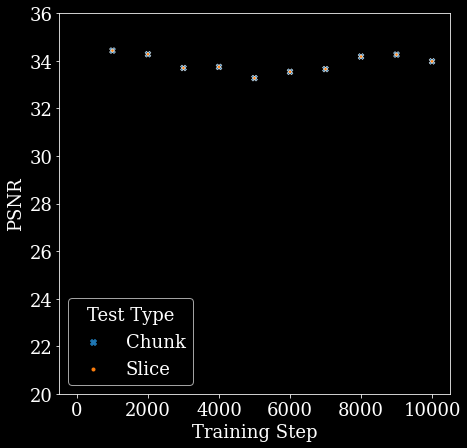

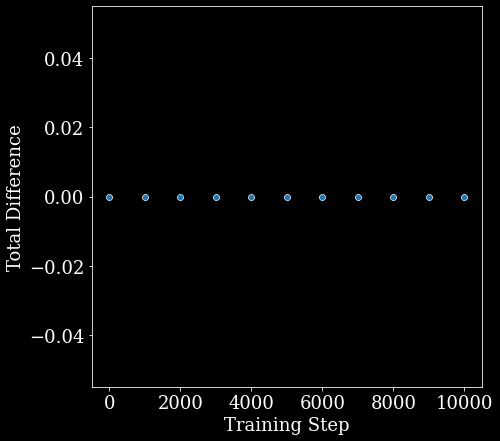

In [109]:
sns.scatterplot(data=metrics['EDSR'], x='Training Step', y='PSNR',
                    hue='Test Type', style='Test Type', markers=['X', '.'])
plt.ylim(20, 36)
plt.show()
sns.scatterplot(data=metrics['valid'], x='Training Step', y='Total Difference')
plt.show()

In [13]:
sr_dir = Path("/home/remedios/data/results/smoreCE/")
sr_files = sorted(sr_dir.iterdir())

In [14]:
sr_files

[PosixPath('/home/remedios/data/results/smoreCE/SUPERRES-ADNIPHANTOM_20200711_PHANTOM-T2-TSE-3D-CORONAL-PRE-ACQ1-02mm_resampled'),
 PosixPath('/home/remedios/data/results/smoreCE/SUPERRES-ADNIPHANTOM_20200711_PHANTOM-T2-TSE-3D-CORONAL-PRE-ACQ1-04mm_resampled'),
 PosixPath('/home/remedios/data/results/smoreCE/SUPERRES-ADNIPHANTOM_20200711_PHANTOM-T2-TSE-3D-CORONAL-PRE-ACQ1-06mm_resampled'),
 PosixPath('/home/remedios/data/results/smoreCE/hyperparam_tuning'),
 PosixPath('/home/remedios/data/results/smoreCE/old')]

In [602]:
sr_files = sorted(filter(lambda x: "iter" in x.name and "FBA" not in x.name and 'two-test' in x.name and '.nii' in x.name, sr_files))

In [603]:
sr_files

[PosixPath('/home/remedios/data/results/smoreCE/SUPERRES-ADNIPHANTOM_20200711_PHANTOM-T2-TSE-2D-CORONAL-PRE-ACQ1-04mm_resampled/iter1_ADNI4x_fullslice_valid_ismoreCE-with-val_espreso_two-test-time-flips_filters=256_ps=64_layers=16.nii'),
 PosixPath('/home/remedios/data/results/smoreCE/SUPERRES-ADNIPHANTOM_20200711_PHANTOM-T2-TSE-2D-CORONAL-PRE-ACQ1-04mm_resampled/iter2_ADNI4x_fullslice_valid_ismoreCE-with-val_espreso_two-test-time-flips_filters=256_ps=64_layers=16.nii'),
 PosixPath('/home/remedios/data/results/smoreCE/SUPERRES-ADNIPHANTOM_20200711_PHANTOM-T2-TSE-2D-CORONAL-PRE-ACQ1-04mm_resampled/iter3_ADNI4x_fullslice_valid_ismoreCE-with-val_espreso_two-test-time-flips_filters=256_ps=64_layers=16.nii'),
 PosixPath('/home/remedios/data/results/smoreCE/SUPERRES-ADNIPHANTOM_20200711_PHANTOM-T2-TSE-2D-CORONAL-PRE-ACQ1-04mm_resampled/iter4_ADNI4x_fullslice_valid_ismoreCE-with-val_espreso_two-test-time-flips_filters=256_ps=64_layers=16.nii'),
 PosixPath('/home/remedios/data/results/smoreCE/

iter1_ADNI4x_fullslice_valid_ismoreCE-with-val_espreso_two-test-time-flips_filters=256_ps=64_layers=16.nii
34.38426682323119
iter2_ADNI4x_fullslice_valid_ismoreCE-with-val_espreso_two-test-time-flips_filters=256_ps=64_layers=16.nii
34.53010342552553
iter3_ADNI4x_fullslice_valid_ismoreCE-with-val_espreso_two-test-time-flips_filters=256_ps=64_layers=16.nii
34.87808255135666
iter4_ADNI4x_fullslice_valid_ismoreCE-with-val_espreso_two-test-time-flips_filters=256_ps=64_layers=16.nii
34.57145563745746
iter5_ADNI4x_fullslice_valid_ismoreCE-with-val_espreso_two-test-time-flips_filters=256_ps=64_layers=16.nii
34.96945298416883
iter6_ADNI4x_fullslice_valid_ismoreCE-with-val_espreso_two-test-time-flips_filters=256_ps=64_layers=16.nii
34.78992501041577
iter7_ADNI4x_fullslice_valid_ismoreCE-with-val_espreso_two-test-time-flips_filters=256_ps=64_layers=16.nii
34.85427748236526
iter8_ADNI4x_fullslice_valid_ismoreCE-with-val_espreso_two-test-time-flips_filters=256_ps=64_layers=16.nii
34.997998495139704

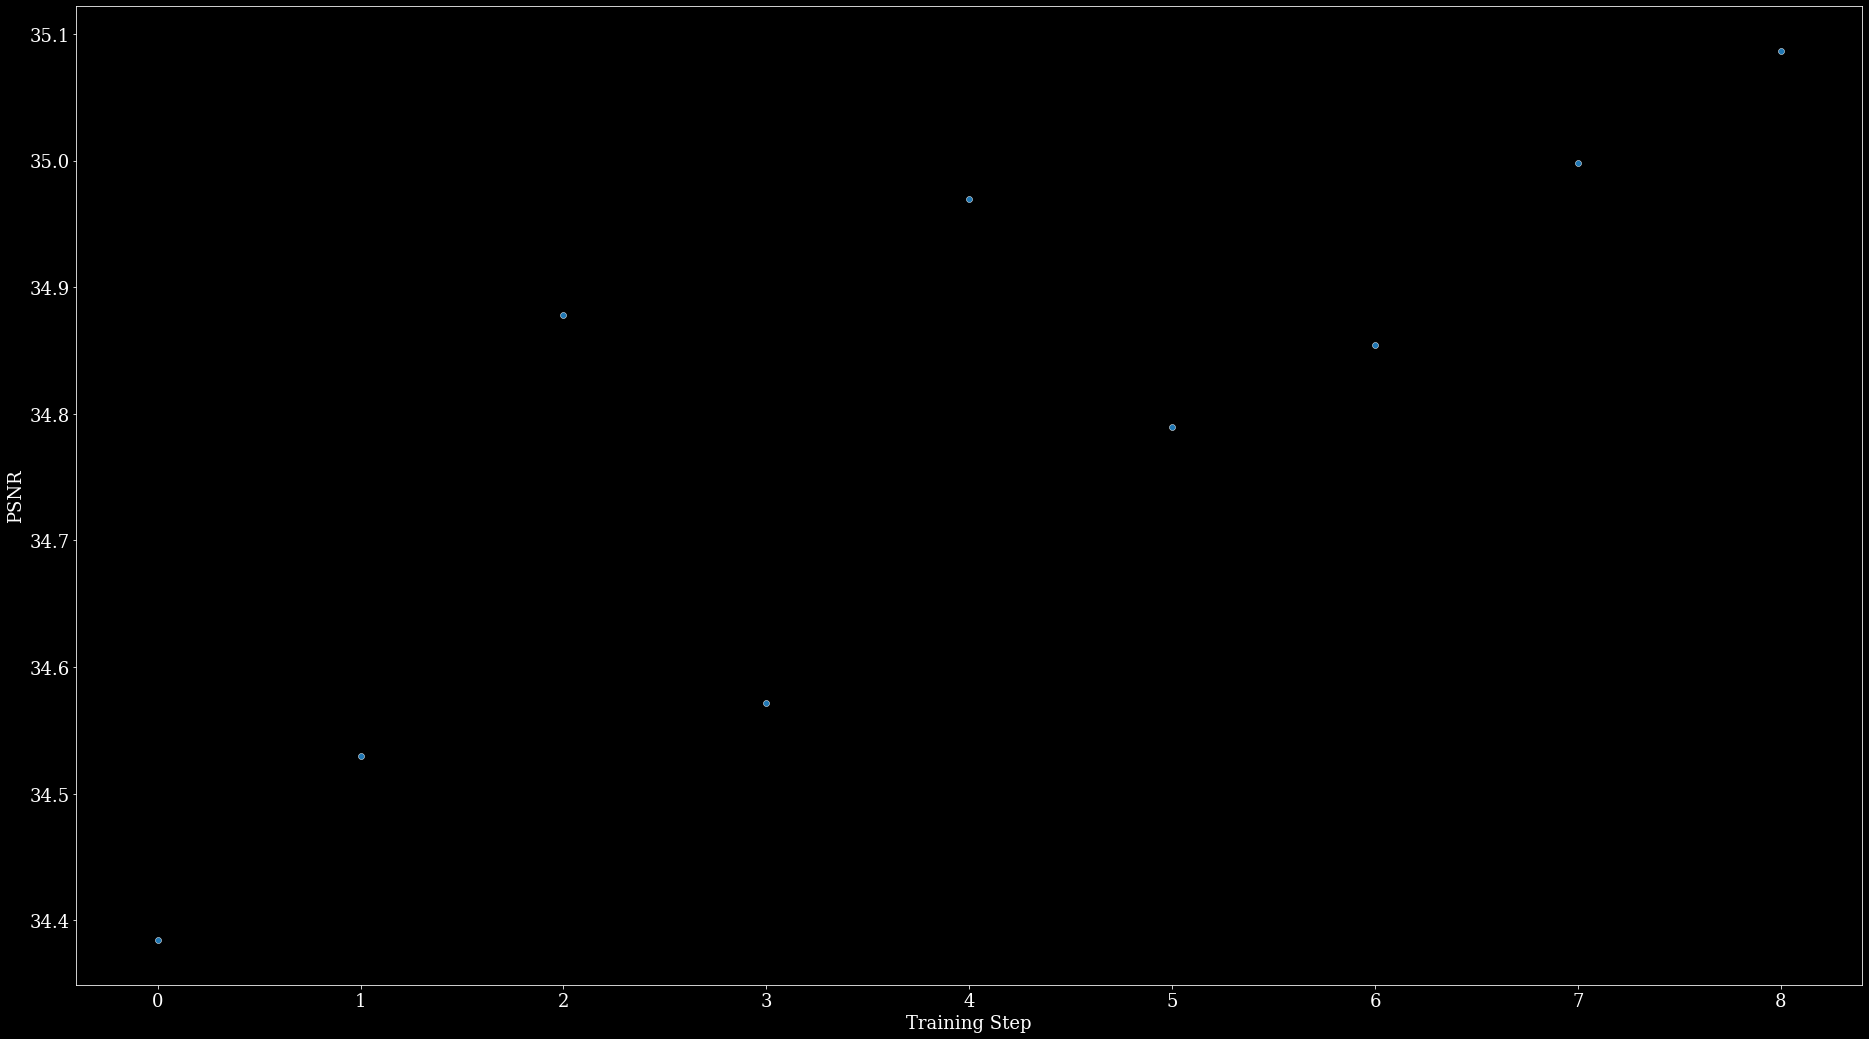

In [605]:
metrics = pd.DataFrame(columns=[
    'PSNR', 
    'Total Difference', 
    'Training Step',
    'val loss',
])

for i, sr_file in enumerate(sr_files):    
    sr = nib.load(sr_file).get_fdata(dtype=np.float32)
    
    sr[sr < 0] = 0
    
    percent_diff = np.abs(sr - gt).sum() / gt.sum()
    
    psnr = peak_signal_noise_ratio(sr, gt, data_range=data_range)

    metrics = metrics.append({'PSNR': psnr, 
                              'Test Type': 'Chunk', 
                              'Total Difference': np.abs(sr - sr_slice).sum(),
                              'Training Step': i,
                              'val loss': val_losses[i],
                             },
                            ignore_index=True)
    
    print(sr_file.name)
    print(psnr)
#     center_vol_plot(sr)
    

sns.scatterplot(data=metrics, x='Training Step', y='PSNR')
# ax2 = plt.twinx()
# sns.scatterplot(data=metrics, x='Training Step', y='val loss', color='orange', ax=ax2)
plt.show()

In [552]:
psnr

34.25689290429265

In [453]:
sr_dir = Path("/home/remedios/data/results/smoreCE/SUPERRES-ADNIPHANTOM_20200711_PHANTOM-T2-TSE-2D-CORONAL-PRE-ACQ1-04mm_resampled/")
sr_files = sorted(sr_dir.iterdir())

In [454]:
sr_files = sorted(filter(lambda x: "valout" in x.name and "FBA" not in x.name, sr_files))

In [455]:
weights_fpath = Path("/home/remedios/data/results/smoreCE/SUPERRES-ADNIPHANTOM_20200711_PHANTOM-T2-TSE-2D-CORONAL-PRE-ACQ1-04mm_resampled/valid_smoreCE-with-val_espreso_filters=256_ps=64_layers=16/weights")
training_steps = list(map(
    lambda x: int(x.name.split("step_")[1][:6]),
    sorted(filter(lambda x: "SR_weights" in x.name, weights_fpath.iterdir()))
))
val_losses = list(map(
    lambda x: float(x.name.split("val-loss_")[1][:6].replace('_', '')),
    sorted(filter(lambda x: "SR_weights" in x.name, weights_fpath.iterdir()))
))

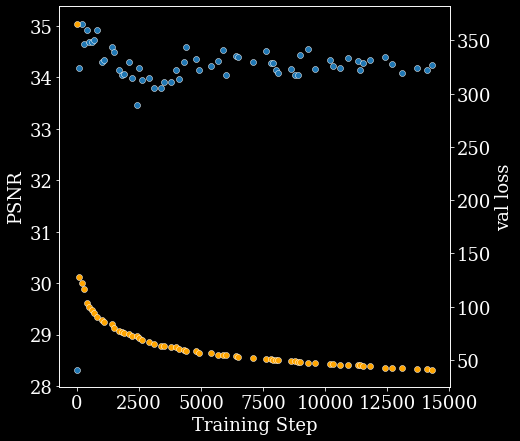

In [456]:
metrics = pd.DataFrame(columns=[
    'PSNR', 
    'Total Difference', 
    'Training Step',
    'val loss',
])

for i, sr_file in enumerate(sr_files):    
    sr = nib.load(sr_file).get_fdata(dtype=np.float32)
    
    percent_diff = np.abs(sr - gt).sum() / gt.sum()
    
    psnr = peak_signal_noise_ratio(sr, gt, data_range=data_range)

    metrics = metrics.append({'PSNR': psnr, 
                              'Test Type': 'Chunk', 
                              'Total Difference': np.abs(sr - sr_slice).sum(),
                              'Training Step': training_steps[i],
                              'val loss': val_losses[i],
                             },
                            ignore_index=True)

sns.scatterplot(data=metrics, x='Training Step', y='PSNR')
ax2 = plt.twinx()
sns.scatterplot(data=metrics, x='Training Step', y='val loss', color='orange', ax=ax2)
plt.show()

In [111]:
from models.net import Net
from models.edsr import EDSR

In [112]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [12]:
# num edsr params
edsr = EDSR(
    n_channels=1,
    patch_size=32,
    kernel_size=3,
    n_resblocks=32,
    filters=256,
    padding_mode='zeros',
    min_clip=0,
)

n_edsr_params = count_parameters(edsr)
edsr = None
del edsr

In [35]:
# edsr metrics
edsr_file = list(filter(lambda s: "EDSR" in s.name and "fullslice" in s.name and "batch" in s.name, 
                         sr_files))[0]

In [31]:
edsr_file

PosixPath('/home/remedios/data/results/smoreCE/SUPERRES-ADNIPHANTOM_20200711_PHANTOM-T2-TSE-2D-CORONAL-PRE-ACQ1-04mm_resampled/SUPERRES-ADNIPHANTOM_20200711_PHANTOM-T2-TSE-2D-CORONAL-PRE-ACQ1-04mm_resampled_fullslice_EDSR_smoreCE_1cycle_256filters_16batch.nii')

In [32]:
sr = nib.load(edsr_file).get_fdata()
psnr = peak_signal_noise_ratio(sr, gt, data_range=data_range)
print(psnr)

35.4134178148897


# Most Recent Net Param Count

In [113]:
# num edsr params
net = Net(
    n_channels=1,
    patch_size=64,
    kernel_size=3,
    n_layers=7,
    filters=256,
)

n_net_params = count_parameters(net)
net = None
del net

In [114]:
n_net_params

2365185

In [116]:
n_edsr_params

38360065

In [117]:
n_net_params / n_edsr_params

0.21548412391897667

In [62]:
from tqdm import tqdm

In [91]:
pbar_dict = {
    'value': 0,
    'extra': 0,
}

In [102]:
# tqdm testing
N = 10000
convergence_counter = 0
convergence_limit = 10

pbar_dict = {
    'value': 0,
    'extra': 0,
    'convergence_counter': convergence_counter
}
with tqdm(total=N) as pbar:
    for i in range(N):
        time.sleep(0.01)
        pbar_dict['value'] = i * 10
        

        if i % 100 == 0:
            for j in range(N//1000):
                time.sleep(0.01)
                if j % 500 == 0:
                    convergence_counter += 1
                    pbar_dict['convergence_counter'] = convergence_counter
                if convergence_counter >= convergence_limit:
                    break
                pbar_dict['extra'] = i * 2
            else:
                continue
            break
                
        pbar.set_postfix({k: f'{v:.2f}' for k, v in pbar_dict.items()})
        pbar.update(1)

  9%|█████▎                                                     | 891/10000 [00:11<01:54, 79.60it/s, value=8990.00, extra=1600.00, convergence_counter=9.00]


# FBA stuff

In [555]:
sr_dir = Path("/home/remedios/data/results/smoreCE/SUPERRES-ADNIPHANTOM_20200711_PHANTOM-T2-TSE-2D-CORONAL-PRE-ACQ1-04mm_resampled/")
sr_files = sorted(sr_dir.iterdir())

In [573]:
sr_files = sorted(filter(lambda x: "more-test-time" in x.name and "FBA" in x.name and '.nii' in x.name, sr_files))

In [574]:
sr_files

[PosixPath('/home/remedios/data/results/smoreCE/SUPERRES-ADNIPHANTOM_20200711_PHANTOM-T2-TSE-2D-CORONAL-PRE-ACQ1-04mm_resampled/ADNI4x_fullslice_valid_smoreCE-with-val_espreso-more-test-time-flips_filters=256_ps=64_layers=16_preFBA_0.nii'),
 PosixPath('/home/remedios/data/results/smoreCE/SUPERRES-ADNIPHANTOM_20200711_PHANTOM-T2-TSE-2D-CORONAL-PRE-ACQ1-04mm_resampled/ADNI4x_fullslice_valid_smoreCE-with-val_espreso-more-test-time-flips_filters=256_ps=64_layers=16_preFBA_1.nii'),
 PosixPath('/home/remedios/data/results/smoreCE/SUPERRES-ADNIPHANTOM_20200711_PHANTOM-T2-TSE-2D-CORONAL-PRE-ACQ1-04mm_resampled/ADNI4x_fullslice_valid_smoreCE-with-val_espreso-more-test-time-flips_filters=256_ps=64_layers=16_preFBA_2.nii'),
 PosixPath('/home/remedios/data/results/smoreCE/SUPERRES-ADNIPHANTOM_20200711_PHANTOM-T2-TSE-2D-CORONAL-PRE-ACQ1-04mm_resampled/ADNI4x_fullslice_valid_smoreCE-with-val_espreso-more-test-time-flips_filters=256_ps=64_layers=16_preFBA_3.nii')]

In [561]:
pre_fba_imgs = [nib.load(f).get_fdata(dtype=np.float32) for f in sr_files]

In [563]:
from utils.fba import fba

In [564]:
for pre_fba_img in pre_fba_imgs:
    psnr = peak_signal_noise_ratio(pre_fba_img, gt, data_range=data_range)
    print(psnr)

34.12274576544024
33.954510454082175
34.09281175523982
33.952457794804744


In [568]:
fba_img = fba(pre_fba_imgs, p=0)
psnr = peak_signal_noise_ratio(fba_img, gt, data_range=data_range)
print(psnr)

34.247861508013415


In [569]:
fba_img = fba(pre_fba_imgs[0:2], p=0)
psnr = peak_signal_noise_ratio(fba_img, gt, data_range=data_range)
print(psnr)

34.24002147643815


In [570]:
fba_img = fba(pre_fba_imgs[0:3], p=0)
psnr = peak_signal_noise_ratio(fba_img, gt, data_range=data_range)
print(psnr)

34.25067716425056


In [571]:
fba_img = fba(pre_fba_imgs[1:3], p=0)
psnr = peak_signal_noise_ratio(fba_img, gt, data_range=data_range)
print(psnr)

34.226713660141144


In [572]:
fba_img = fba(pre_fba_imgs[3:], p=0)
psnr = peak_signal_noise_ratio(fba_img, gt, data_range=data_range)
print(psnr)

33.95245779480473


In [328]:
fba_p_psnrs = []
for p in tqdm(range(30)):
    fba_img = fba([a, b], p=p)
    # postprocess: clip to the original range from the LR image
    fba_img[fba_img < 0] = 0
    fba_img[fba_img > gt.max()] = gt.max()
    psnr = peak_signal_noise_ratio(fba_img, gt, data_range=data_range)
    fba_p_psnrs.append(psnr)
    
fba_img = fba([a, b], p='inf')
psnr = peak_signal_noise_ratio(fba_img, gt, data_range=data_range)
fba_p_psnrs.append(psnr)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:01<00:00,  2.05s/it]


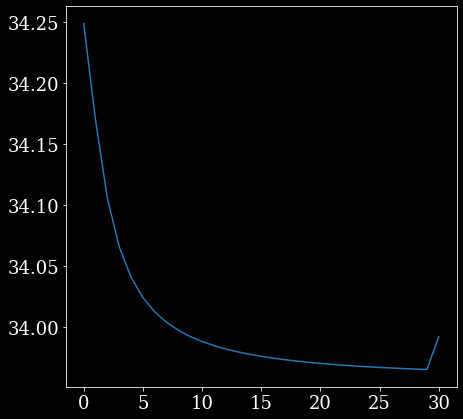

In [329]:
plt.plot(fba_p_psnrs)